# Stellar-to-halo mass relation: $R_{200}$ estimator

Here I validate the code to estimate the $R_{200}$ based on the stellar-to-halo mass relation.

In [1]:
import matplotlib.pyplot as plt
from astropy import units as u
import numpy as np
from scipy.interpolate import interp1d

### Define Cosmology
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
H0 = 70
cosmo = FlatLambdaCDM(H0=H0, Om0=0.283)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# validate this class
from r200_shmr import r200SHMR

In [3]:
colors = ['firebrick']
def save_fig(fig,fname):
    fig.savefig(fname, dpi=100, facecolor='w', transparent=False)

## Validation Sample: SDSS

Note the redshift catalog from the SDSS redshift sample is not complete in the cluster regions. There's an issue with the fiber colision.

In [4]:
import sys
sys.path.append('/Users/jesteves/Documents/GitHub/galaxyFormation/scripts')
from file_loc import FileLocs

In [5]:
fl = FileLocs(dataset='sdss', root='/Users/jesteves/Documents/GitHub/galaxyFormation/data/')
cat = fl.load_catalogs('cluster/main')
gal0 = fl.load_catalogs('galaxy/main')

mask  = (gal0['VLOS_MASK']).astype(bool)
mask &= gal0['VOLUME_LIM_MASK'].astype(bool)
gal = gal0[mask]

Loading Catalog: /Users/jesteves/Documents/GitHub/galaxyFormation/data/catalogs/SDSS/groupCatalog_Yang_deCarvalho2017.csv
Loading Catalog: /Users/jesteves/Documents/GitHub/galaxyFormation/data/catalogs/SDSS/groups_deCarvalho2017_5xR200m_galaxies_johnnyheq_pp.csv


In [6]:
cat#[10:]

Yang,RA,DEC,redshift,N200,logM200c,logM200m,R200c,R200m,thetaR200,thetaR200m,vcirc_c,vcirc_m
int64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64
2,240.5602,16.1113,0.035999998450279236,525,15.444902420043945,15.61043080796355,2.8714284896850586,3.880159897239745,0.7795811316295294,1.0534475724189225,2041.7840576171875,1887.7175813096123
4,247.1149,40.8317,0.029999999329447746,217,14.814902305603027,14.988838641010085,1.7714285850524902,2.4220034873237517,0.5730670271152717,0.7835316364742502,1257.8946533203125,1168.0954840010763
5,247.1633,39.4674,0.029999999329447746,277,14.9649019241333,15.138926939889993,2.0,2.7177167877362454,0.6470111436516279,0.8791965384498562,1411.3817138671875,1310.7135159645927
6,167.6936,28.5374,0.032999999821186066,167,14.754902839660645,14.927840689026137,1.6857142448425293,2.3045122256737995,0.4975147606695648,0.6801442623443363,1201.785400390625,1116.2906247336416
7,351.1194,14.6251,0.041999999433755875,106,14.664902687072754,14.835094504183962,1.571428656578064,2.127630582418425,0.36826592735879554,0.4986124388818472,1122.9947509765625,1044.1083602597816
8,239.5372,27.3133,0.09000000357627869,183,15.254901885986328,15.411329095121902,2.442857265472412,3.1653055595608754,0.28232277514615234,0.3658166554840595,1778.5684814453125,1661.893369756073
...,...,...,...,...,...,...,...,...,...,...,...,...
625,242.3892,53.0522,0.06300000101327896,22,14.454901695251465,14.618135149740072,1.3285714387893677,1.76567550925269,0.2126872311457515,0.28266198128345965,958.7020263671875,892.8090091625098
628,325.7397,-6.8996,0.05400000140070915,40,14.494901657104492,14.660616473488858,1.3714286088943481,1.839771927974334,0.25348939806987825,0.34005610630577116,987.310546875,918.4862740091069


# $M_{200,SHMR}$ without noise

First, we ask ourselves what is the predicted accuracy of $M_{200,SHMR}$ using the fact that we know the true stellar mass of the cluster.

In [7]:
# mask = np.where((gal['orbital']=='False')|(gal['infall']=='False'),False, True)
orbitall = np.where(gal['orbital']=='False',False, True)
interlopers = np.where(gal['interlopers']=='False',False, True)
infall = np.where(gal['infall']=='False',False, True)

mask = orbitall| infall

mask &= gal['Rm']<=2.
gid = gal['Yang'][mask]
smass = gal['mass'][mask]
radii = gal['Rc'][mask]

## Intrisec Error

In [8]:
# all galaxies inside r200c
keys = [np.where(gid==cid)[0] for cid in np.array(cat['Yang'])]

nobjects = []
r200p, m200p = [], []
for i,idx in enumerate(keys):
    cid = cat['Yang'][i]
    nbins = int(radii[idx].size/5.)+1
    print(f'CID, nbins: {cid} {nbins}')
    rbins = np.percentile(radii[idx], np.linspace(0,100,nbins) )
    rModel = r200SHMR(rbins, model_name='zu_mandelbaum15' , sigma_bg=0)
    rModel.fit(smass[idx], radii[idx], bias=0)
    nobjects.append(idx.size)
    
    # halo mass at R200c
    m200c = np.log10(interp1d(rModel.rmed, rModel.shmr_halo_mass, fill_value='extrapolate')(1.))
    r200p.append(rModel.r200c)
    m200p.append(rModel.m200c)
    
r200p = np.array(r200p)
m200p = np.array(m200p)
nobjects = np.array(nobjects)

CID, nbins: 2 139
CID, nbins: 4 69
CID, nbins: 5 85
CID, nbins: 6 41
CID, nbins: 7 30
CID, nbins: 8 48


/usr/local/anaconda/lib/python3.8/site-packages/halotools/empirical_models/factories/prebuilt_model_factory.py:258: UserWarning: This particular model is still being tested in collaboration with Ying Zu.
If you need to use this prebuilt model for science, 
you will either need to test it yourself 
or wait for the Halotools developers to finish science verification.

  warn(under_development_warning.format("Ying Zu"))


CID, nbins: 9 37
CID, nbins: 10 27
CID, nbins: 11 36
CID, nbins: 12 28
CID, nbins: 14 26
CID, nbins: 15 28
CID, nbins: 16 30
CID, nbins: 17 30
CID, nbins: 18 23
CID, nbins: 20 71
CID, nbins: 21 43
CID, nbins: 22 24
CID, nbins: 23 49
CID, nbins: 24 22
CID, nbins: 25 25
CID, nbins: 26 22
CID, nbins: 27 19
CID, nbins: 28 25
CID, nbins: 29 21
CID, nbins: 30 20
CID, nbins: 31 26
CID, nbins: 32 23
CID, nbins: 34 26
CID, nbins: 35 14
CID, nbins: 36 26
CID, nbins: 37 86
CID, nbins: 38 20
CID, nbins: 39 15
CID, nbins: 40 19
CID, nbins: 41 19
CID, nbins: 42 28
CID, nbins: 44 18
CID, nbins: 45 37
CID, nbins: 46 19
CID, nbins: 47 62
CID, nbins: 48 19
CID, nbins: 49 20
CID, nbins: 50 20
CID, nbins: 51 15
CID, nbins: 52 16
CID, nbins: 53 20
CID, nbins: 54 31
CID, nbins: 57 17
CID, nbins: 58 14
CID, nbins: 61 22
CID, nbins: 62 19
CID, nbins: 64 12
CID, nbins: 65 20
CID, nbins: 66 21
CID, nbins: 68 15
CID, nbins: 69 18
CID, nbins: 70 15
CID, nbins: 71 19
CID, nbins: 73 24
CID, nbins: 74 15
CID, nbins:

In [9]:
r200c = np.array(cat['R200c'])
m200c = np.array(cat['logM200c'])
redshift = np.array(cat['redshift'])

In [10]:
bias = np.median(m200p-m200c)
bias

-0.061918463370222554

In [11]:
def convertM200toR200_z(M200,z,delta=200):
    ## M200 in solar masses
    ## R200 in Mpc
    rhoc = (cosmo.critical_density(z).to(u.Msun/u.Mpc**3)).value # Msun/Mpc^3
    R200 = ( M200/(delta*4*np.pi*rhoc/3) )**(1/3.)
    return R200

def get_scatter_label(x,y,is_log=False,scale=1):
    res = x/y
    if is_log:
        res = np.log10(res)
        
    nmask = np.abs(res-1)<1.
    return r'$\sigma_{68} =%.2f$'%np.std(scale*res[nmask])#(0.5*(p84-p16))

In [12]:
r200p = convertM200toR200_z(10**(m200p), redshift)

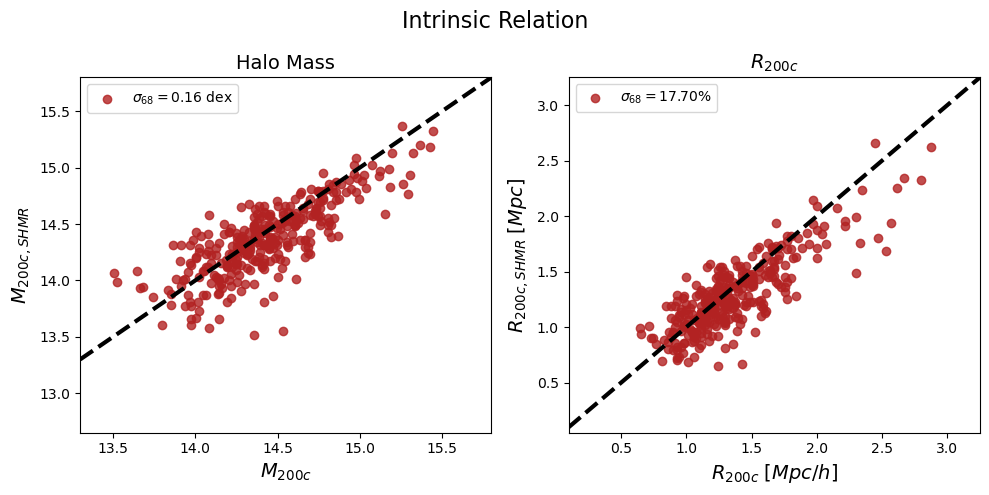

In [13]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)

mmin, mmax = 13.3, 15.8
ix = np.argsort(redshift)
label = get_scatter_label(10**m200c, 10**m200p, is_log=True)+' dex'

plt.plot([mmin, mmax],[mmin, mmax],'k--',lw=3)
plt.scatter(m200c[ix], m200p[ix], color=colors[0], alpha=0.8, label=label)
plt.legend()
plt.xlabel(r'$M_{200c}$',fontsize=14)
plt.ylabel(r'$M_{200c,SHMR}$',fontsize=14)
plt.title('Halo Mass',fontsize=14)
plt.xlim(mmin,mmax)
plt.ylim(mmin-0.65,mmax)

plt.subplot(1,2,2)
rmin, rmax = 0.1, 3.25
label = get_scatter_label(r200c, r200p, scale=100) +'%'

ix = np.argsort(nobjects)
plt.plot([rmin, rmax],[rmin, rmax],'k--',lw=3)
im = plt.scatter(r200c[ix], r200p[ix], color=colors[0], alpha=0.8, label=label)
plt.legend()
plt.xlabel(r'$R_{200c} \; [Mpc/h]$',fontsize=14)
plt.ylabel(r'$R_{200c,SHMR}\; [Mpc]$',fontsize=14)
plt.title('$R_{200c}$',fontsize=14)
plt.xlim(rmin,rmax)
plt.ylim(rmin-0.05,rmax)
plt.suptitle('Intrinsic Relation', fontsize=16)
plt.tight_layout()
save_fig(plt, 'pannel_intrinsic_relation.png')

Text(0.5, 1.0, 'True SHRM ')

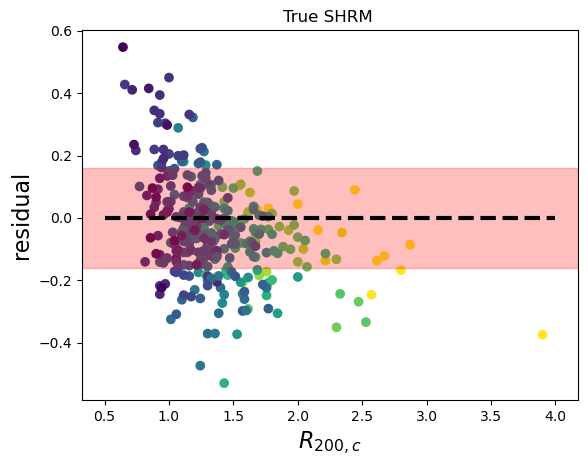

In [14]:
res = r200p/r200c-1
nmask = np.abs(res)>0.

plt.plot([0.5, 4.],[0, 0],'k--',lw=3)
plt.scatter(r200c[nmask], res[nmask], c=np.log10(nobjects)[nmask],vmin=np.log10(20),vmax=np.log10(200))
plt.axhspan(-1*np.std(res[nmask]), 1*np.std(res[nmask]), alpha=0.25, color='r')
# plt.xscale('log')
plt.xlabel('$R_{200,c}$',fontsize=16)
plt.ylabel('residual',fontsize=16)
plt.title('True SHRM ')

Text(0.5, 0, 'redshift')

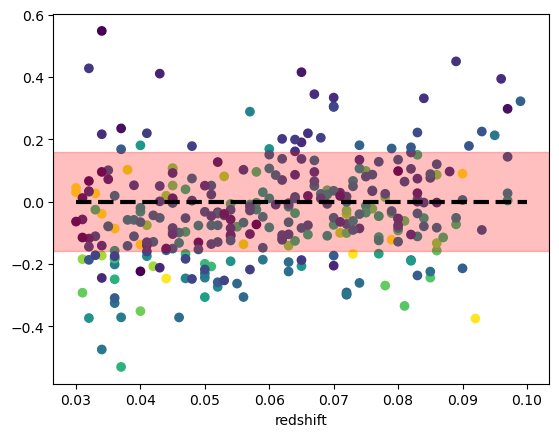

In [15]:
plt.plot([0.03, 0.1],[0, 0],'k--',lw=3)
plt.scatter(redshift[nmask], res[nmask], c=np.log10(nobjects)[nmask],vmin=np.log10(20),vmax=np.log10(200))
plt.axhspan(-1*np.std(res[nmask]), 1*np.std(res[nmask]), alpha=0.25, color='r')
# plt.xscale('log')
plt.xlabel('redshift')

There is an intrisic error with R200c. 

# Background Subtaction

In [16]:
def compute_background_denstiy(idx):
    x = rm[idx]
    y = 10**smass[idx]
    rb = np.percentile(x,[0,100])
    area = np.pi*(np.max(rv[idx])**2 - np.min(rv[idx])**2)
    sigmabg = np.log10(np.sum(y)/area)
    
    sigmabg = np.where(np.isfinite(sigmabg),sigmabg,10.3)
    #sigmabg = np.log10(np.sum(10**smass[field]/(area[field])))
    print('Stellar Mass Background Density Contamination %.2f [M$_{\odot}$/Mpc^2]'%(sigmabg))
    return sigmabg

In [17]:
gid = gal['Yang']
smass = gal['mass']
rm = gal['Rm']
rv = (gal['Rm']*gal['R200m'])

orbitall = np.where(gal['orbital']=='False',False, True)
interlopers = np.where(gal['interlopers']=='False',False, True)
infall = np.where(gal['infall']=='False',False, True)

field = (interlopers)|(infall)

In [18]:
keys_bkg = [np.where((gid==cid) & (rm<=4) & (rm>3) & field)[0] for cid in np.array(cat['Yang'])]
sigma_bkg = np.array([compute_background_denstiy(ix) for ix in keys_bkg])


Stellar Mass Background Density Contamination 10.53 [M$_{\odot}$/Mpc^2]
Stellar Mass Background Density Contamination 10.31 [M$_{\odot}$/Mpc^2]
Stellar Mass Background Density Contamination 10.32 [M$_{\odot}$/Mpc^2]
Stellar Mass Background Density Contamination 10.47 [M$_{\odot}$/Mpc^2]
Stellar Mass Background Density Contamination 9.86 [M$_{\odot}$/Mpc^2]
Stellar Mass Background Density Contamination 10.82 [M$_{\odot}$/Mpc^2]
Stellar Mass Background Density Contamination 10.86 [M$_{\odot}$/Mpc^2]
Stellar Mass Background Density Contamination 10.28 [M$_{\odot}$/Mpc^2]
Stellar Mass Background Density Contamination 9.97 [M$_{\odot}$/Mpc^2]
Stellar Mass Background Density Contamination 9.80 [M$_{\odot}$/Mpc^2]
Stellar Mass Background Density Contamination 10.54 [M$_{\odot}$/Mpc^2]
Stellar Mass Background Density Contamination 10.29 [M$_{\odot}$/Mpc^2]
Stellar Mass Background Density Contamination 10.55 [M$_{\odot}$/Mpc^2]
Stellar Mass Background Density Contamination 10.24 [M$_{\odot}$/Mp

## Check Accuracy

In [19]:
# all galaxies inside 5Mpc
keys = [np.where((gid==cid)& (rv<=5.0))[0] for cid in np.array(cat['Yang'])]

rModels, nobjects = [], []
for i,idx in enumerate(keys):
    cid = cat['Yang'][i]
    nbins = int(rv[idx].size/5.)+1
    sbg = sigma_bkg[i]
    
    print(f'CID, nbins: {cid} {nbins}')
    rbins = np.percentile(rv[idx], np.linspace(0,100,nbins) )
    rModel = r200SHMR(rbins, model_name='zu_mandelbaum15' , sigma_bg=sbg)
    rModel.fit(smass[idx], rv[idx], bias=-0.2, fit_der=True)
    nobjects.append(idx.size)
    
    # halo mass at R200c
    m200c = np.log10(interp1d(rModel.rmed, rModel.shmr_halo_mass, fill_value='extrapolate')(1.))
    rModels.append(rModel)

CID, nbins: 2 130
CID, nbins: 4 94
CID, nbins: 5 95
CID, nbins: 6 78
CID, nbins: 7 43
CID, nbins: 8 57
CID, nbins: 9 68
CID, nbins: 10 47
CID, nbins: 11 49
CID, nbins: 12 39
CID, nbins: 14 42
CID, nbins: 15 32
CID, nbins: 16 60
CID, nbins: 17 40
CID, nbins: 18 47
CID, nbins: 20 116
CID, nbins: 21 44
CID, nbins: 22 37
CID, nbins: 23 53
CID, nbins: 24 73
CID, nbins: 25 40
CID, nbins: 26 23
CID, nbins: 27 39
CID, nbins: 28 30
CID, nbins: 29 32
CID, nbins: 30 34
CID, nbins: 31 35
CID, nbins: 32 28
CID, nbins: 34 35
CID, nbins: 35 22
CID, nbins: 36 34
CID, nbins: 37 103
CID, nbins: 38 28
CID, nbins: 39 29
CID, nbins: 40 38
CID, nbins: 41 39
CID, nbins: 42 41
CID, nbins: 44 65
CID, nbins: 45 34
CID, nbins: 46 28
CID, nbins: 47 113
CID, nbins: 48 27
CID, nbins: 49 43
CID, nbins: 50 30
CID, nbins: 51 23
CID, nbins: 52 26
CID, nbins: 53 24
CID, nbins: 54 36
CID, nbins: 57 33
CID, nbins: 58 23
CID, nbins: 61 26
CID, nbins: 62 27
CID, nbins: 64 21
CID, nbins: 65 50
CID, nbins: 66 30
CID, nbins: 6

/Users/jesteves/Documents/GitHub/fnalFall2022/r200/r200_shmr.py:193: RankWarning: Polyfit may be poorly conditioned
  sm = smoothP(self.rmed_cut, self.shmr_halo_mass_updated, p, deriv=0)
/Users/jesteves/Documents/GitHub/fnalFall2022/r200/r200_shmr.py:194: RankWarning: Polyfit may be poorly conditioned
  d1 = smoothP(self.rmed_cut, self.shmr_halo_mass_updated, p, deriv=1)
/Users/jesteves/Documents/GitHub/fnalFall2022/r200/r200_shmr.py:195: RankWarning: Polyfit may be poorly conditioned
  d2 = smoothP(self.rmed_cut, self.shmr_halo_mass_updated, p, deriv=2)


CID, nbins: 247 27
CID, nbins: 250 28
CID, nbins: 253 39
CID, nbins: 254 14
CID, nbins: 255 22
CID, nbins: 256 19
CID, nbins: 258 20
CID, nbins: 259 19
CID, nbins: 260 17
CID, nbins: 263 24
CID, nbins: 265 22
CID, nbins: 267 15
CID, nbins: 268 20
CID, nbins: 269 9
CID, nbins: 272 20
CID, nbins: 275 18
CID, nbins: 276 17
CID, nbins: 278 15
CID, nbins: 279 15
CID, nbins: 280 16
CID, nbins: 281 15
CID, nbins: 282 17
CID, nbins: 283 30
CID, nbins: 287 14
CID, nbins: 289 17
CID, nbins: 290 23
CID, nbins: 292 16
CID, nbins: 294 13
CID, nbins: 295 15
CID, nbins: 297 17
CID, nbins: 298 18
CID, nbins: 300 12
CID, nbins: 301 20
CID, nbins: 302 27
CID, nbins: 303 20
CID, nbins: 304 19
CID, nbins: 305 14
CID, nbins: 306 16
CID, nbins: 308 23
CID, nbins: 309 25
CID, nbins: 310 10
CID, nbins: 311 14
CID, nbins: 313 15
CID, nbins: 314 27
CID, nbins: 316 27
CID, nbins: 319 22
CID, nbins: 322 14
CID, nbins: 327 20
CID, nbins: 328 20
CID, nbins: 330 14
CID, nbins: 331 16
CID, nbins: 333 14
CID, nbins: 3

/Users/jesteves/Documents/GitHub/fnalFall2022/r200/r200_shmr.py:193: RankWarning: Polyfit may be poorly conditioned
  sm = smoothP(self.rmed_cut, self.shmr_halo_mass_updated, p, deriv=0)
/Users/jesteves/Documents/GitHub/fnalFall2022/r200/r200_shmr.py:194: RankWarning: Polyfit may be poorly conditioned
  d1 = smoothP(self.rmed_cut, self.shmr_halo_mass_updated, p, deriv=1)
/Users/jesteves/Documents/GitHub/fnalFall2022/r200/r200_shmr.py:195: RankWarning: Polyfit may be poorly conditioned
  d2 = smoothP(self.rmed_cut, self.shmr_halo_mass_updated, p, deriv=2)


CID, nbins: 467 9
CID, nbins: 471 19
CID, nbins: 480 12
CID, nbins: 496 22
CID, nbins: 501 22
CID, nbins: 503 24
CID, nbins: 509 27
CID, nbins: 511 12
CID, nbins: 513 23
CID, nbins: 526 16
CID, nbins: 529 24
CID, nbins: 530 10
CID, nbins: 532 11
CID, nbins: 540 13
CID, nbins: 542 21
CID, nbins: 554 16
CID, nbins: 557 17
CID, nbins: 559 11
CID, nbins: 562 15
CID, nbins: 564 16
CID, nbins: 567 17
CID, nbins: 574 13
CID, nbins: 577 13
CID, nbins: 586 7
CID, nbins: 595 16
CID, nbins: 599 11
CID, nbins: 608 17
CID, nbins: 616 15
CID, nbins: 621 19
CID, nbins: 624 16
CID, nbins: 625 19
CID, nbins: 628 16
CID, nbins: 630 22
CID, nbins: 631 11
CID, nbins: 635 16
CID, nbins: 664 21
CID, nbins: 665 47


In [20]:
r200p, m200p = [], []
r200p_der, m200p_der = [], []
for rModel in rModels:
    r200p.append(rModel.r200c)
    m200p.append(rModel.m200c)
    r200p_der.append(rModel.r200c_der)
    m200p_der.append(rModel.m200c_der)
    
r200p = np.array(r200p)
m200p = np.array(m200p)
r200p_der = np.array(r200p_der)
m200p_der = np.array(m200p_der)

nobjects = np.array(nobjects)

In [21]:
m200c = np.array(cat['logM200c'])
r200c = np.array(cat['R200c'])
redshift = np.array(cat['redshift'])

In [22]:
bias = np.median(m200p-m200c)
bias

0.04404727608119963

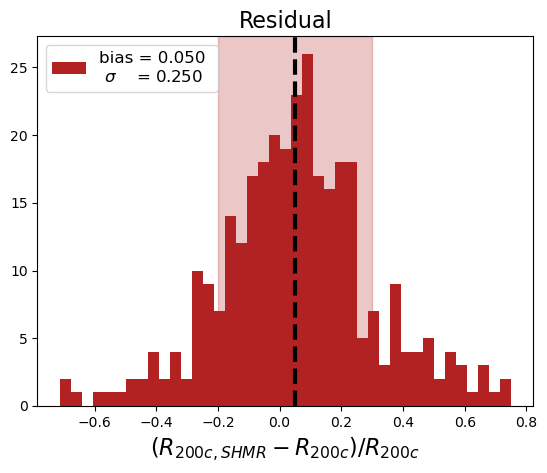

In [23]:
res = (r200p-r200c)/r200c
rms_error = np.std(res[np.abs(res)<1.])
bias = np.nanmedian(res)

label = 'bias = %.3f \n $\\sigma$    = %.3f'%(bias, rms_error)
_ = plt.hist(res,bins=41,color=colors[0],label=label)
plt.axvline(bias,ls='--',lw=3,color='k')
plt.axvspan(-rms_error+bias,rms_error+bias,color=colors[0],alpha=0.25)
plt.legend(fontsize=12)
plt.xlabel(r'$(R_{200c,SHMR}-R_{200c})/R_{200c}$',fontsize=16)
plt.title('Residual',fontsize=16)

save_fig(plt, 'r200c_residual_bkg_sub.png')

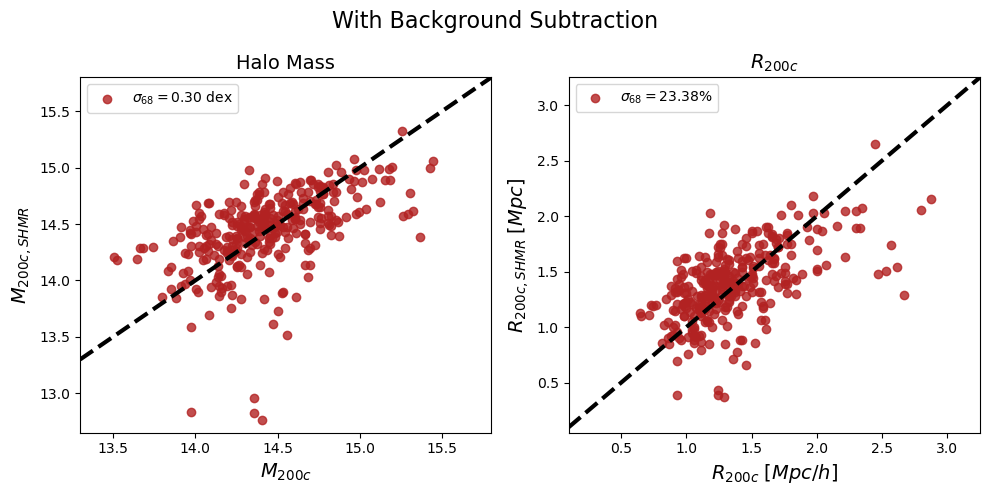

In [24]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)

mmin, mmax = 13.3, 15.8
ix = np.argsort(redshift)
label = get_scatter_label(10**m200c, 10**m200p, is_log=True)+' dex'

plt.plot([mmin, mmax],[mmin, mmax],'k--',lw=3)
plt.scatter(m200c[ix], m200p[ix], color=colors[0], alpha=0.8, label=label)
plt.legend()
plt.xlabel(r'$M_{200c}$',fontsize=14)
plt.ylabel(r'$M_{200c,SHMR}$',fontsize=14)
plt.title('Halo Mass',fontsize=14)
plt.xlim(mmin,mmax)
plt.ylim(mmin-0.65,mmax)

plt.subplot(1,2,2)
rmin, rmax = 0.1, 3.25
label = get_scatter_label(r200c, r200p, scale=100) +'%'

ix = np.argsort(nobjects)
plt.plot([rmin, rmax],[rmin, rmax],'k--',lw=3)
im = plt.scatter(r200c[ix], r200p[ix], color=colors[0], alpha=0.8, label=label)
plt.legend()
plt.xlabel(r'$R_{200c} \; [Mpc/h]$',fontsize=14)
plt.ylabel(r'$R_{200c,SHMR}\; [Mpc]$',fontsize=14)
plt.title('$R_{200c}$',fontsize=14)
plt.xlim(rmin,rmax)
plt.ylim(rmin-0.05,rmax)
plt.suptitle('With Background Subtraction', fontsize=16)
plt.tight_layout()

save_fig(plt, 'pannel_with_bkg_sub.png')

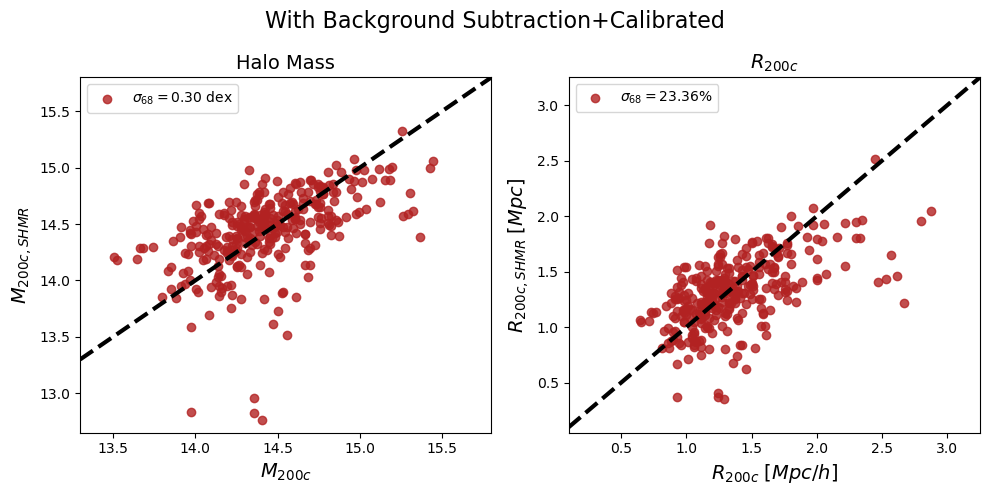

In [25]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)

mmin, mmax = 13.3, 15.8
ix = np.argsort(redshift)
label = get_scatter_label(10**m200c, 10**m200p, is_log=True)+' dex'

plt.plot([mmin, mmax],[mmin, mmax],'k--',lw=3)
plt.scatter(m200c[ix], m200p[ix], color=colors[0], alpha=0.8, label=label)
plt.legend()
plt.xlabel(r'$M_{200c}$',fontsize=14)
plt.ylabel(r'$M_{200c,SHMR}$',fontsize=14)
plt.title('Halo Mass',fontsize=14)
plt.xlim(mmin,mmax)
plt.ylim(mmin-0.65,mmax)

plt.subplot(1,2,2)
rmin, rmax = 0.1, 3.25
label = get_scatter_label(r200c, (1-bias)*r200p, scale=100) +'%'
res = (r200p-r200c)/r200c
rms_error = np.std(res[np.abs(res)<1.])
bias = np.median(res)

ix = np.argsort(nobjects)
plt.plot([rmin, rmax],[rmin, rmax],'k--',lw=3)
im = plt.scatter(r200c[ix], (1-bias)*r200p[ix], color=colors[0], alpha=0.8, label=label)
plt.legend()
plt.xlabel(r'$R_{200c} \; [Mpc/h]$',fontsize=14)
plt.ylabel(r'$R_{200c,SHMR}\; [Mpc]$',fontsize=14)
plt.title('$R_{200c}$',fontsize=14)
plt.xlim(rmin,rmax)
plt.ylim(rmin-0.05,rmax)
plt.suptitle('With Background Subtraction+Calibrated', fontsize=16)
plt.tight_layout()

save_fig(plt, 'pannel_with_bkg_sub_calb.png')

## Derivative Method

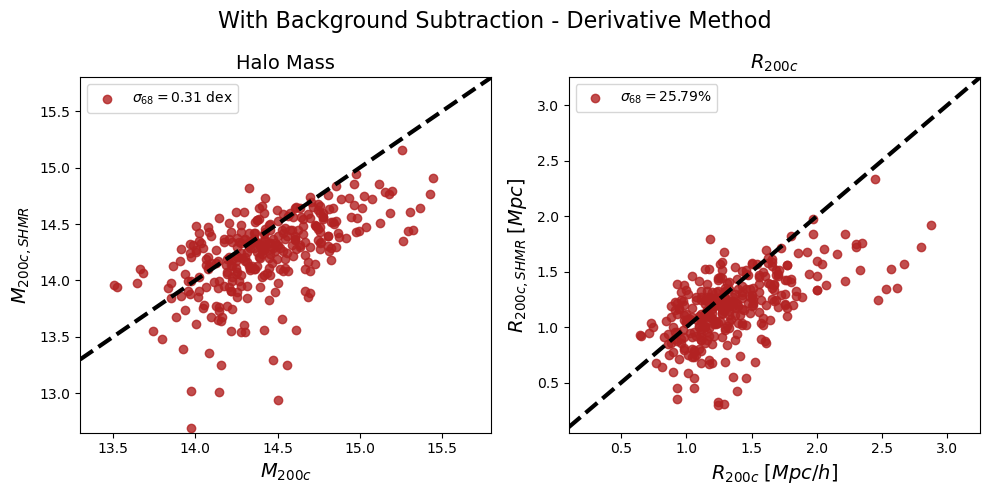

In [26]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)

mmin, mmax = 13.3, 15.8
ix = np.argsort(redshift)
label = get_scatter_label(10**m200c, 10**m200p_der, is_log=True)+' dex'

plt.plot([mmin, mmax],[mmin, mmax],'k--',lw=3)
plt.scatter(m200c[ix], m200p_der[ix], color=colors[0], alpha=0.8, label=label)
plt.legend()
plt.xlabel(r'$M_{200c}$',fontsize=14)
plt.ylabel(r'$M_{200c,SHMR}$',fontsize=14)
plt.title('Halo Mass',fontsize=14)
plt.xlim(mmin,mmax)
plt.ylim(mmin-0.65,mmax)

plt.subplot(1,2,2)
rmin, rmax = 0.1, 3.25
label = get_scatter_label(r200c, r200p_der, scale=100) +'%'

ix = np.argsort(nobjects)
plt.plot([rmin, rmax],[rmin, rmax],'k--',lw=3)
im = plt.scatter(r200c[ix], r200p_der[ix], color=colors[0], alpha=0.8, label=label)
plt.legend()
plt.xlabel(r'$R_{200c} \; [Mpc/h]$',fontsize=14)
plt.ylabel(r'$R_{200c,SHMR}\; [Mpc]$',fontsize=14)
plt.title('$R_{200c}$',fontsize=14)
plt.xlim(rmin,rmax)
plt.ylim(rmin-0.05,rmax)
plt.suptitle('With Background Subtraction - Derivative Method', fontsize=16)
plt.tight_layout()

# Example: 200 times the critical density of the universe

In [27]:
i = 5
rModel = rModels[i]
r200ci = r200c[i]
m200ci = m200c[i]
zcls = redshift[i]

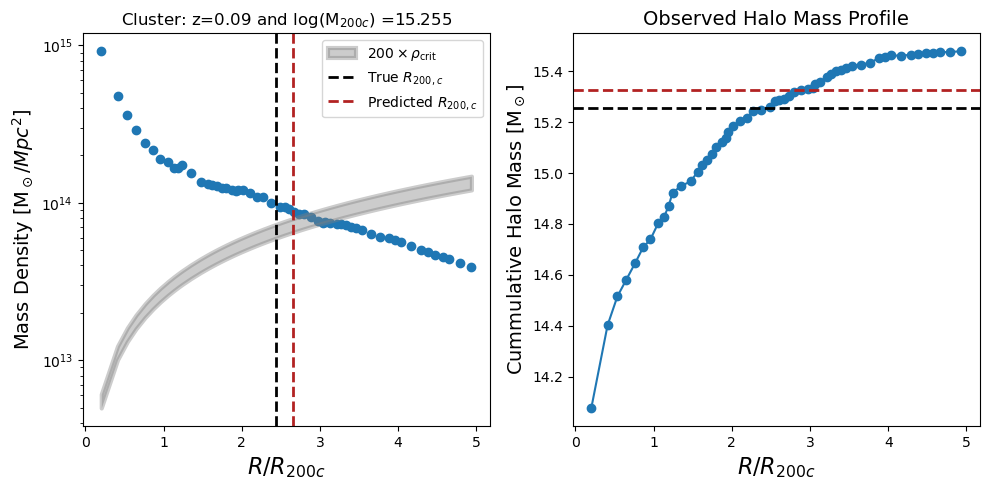

In [30]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(rModel.rmed, rModel.shmr_mass_density)

dX = 20
plt.fill_between(rModel.rmed, (200-dX)*rModel._rhoc*rModel.rmed, (200+dX)*rModel._rhoc*rModel.rmed,color='gray',
                 alpha=0.4, lw=3,label=r'$200 \times \rho_{\rm crit}$')

plt.axvline(r200c[i], color='k',ls='--',lw=2,label='True $R_{200,c}$')
plt.axvline(rModel.r200c,color=colors[0],ls='--',lw=2,label='Predicted $R_{200,c}$')
plt.yscale('log')

plt.xlabel(r'$R/R_{200c}$', fontsize=16)
plt.ylabel(r'Mass Density [M$_\odot/Mpc^2$]',fontsize=14)
plt.title('Cluster: z=%.2f and log(M$_{200c}$) =%.3f'%(zcls, m200c[i]))
plt.legend()


plt.subplot(1,2,2)
# plt.loglog()
plt.scatter(rModel.rmed, rModel.shmr_halo_mass)
plt.plot(rModel.rmed, rModel.shmr_halo_mass)
plt.axhline(m200c[i], color='k',ls='--',lw=2,label='True $M_{200,c}$')
plt.axhline(rModel.m200c,color=colors[0],ls='--',lw=2,label='Predicted $R_{200,c}$')

plt.xlabel(r'$R/R_{200c}$', fontsize=16)
plt.ylabel(r'Cummulative Halo Mass [M$_\odot$]',fontsize=14)
plt.title('Observed Halo Mass Profile',fontsize=14)
plt.tight_layout()

# plt.suptitle('SDSS')
# plt.title('Cluster: z=%.2f and log(M$_{200c}$) =%.3f'%(zcls, m200c))

save_fig(plt, 'mass_density_profile_example.png')

In [29]:
from halotools.empirical_models import PrebuiltHodModelFactory
from scipy.integrate import simps
from scipy.interpolate import interp1d
import numpy as np

### Define Cosmology
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
H0 = 70
cosmo = FlatLambdaCDM(H0=H0, Om0=0.283)

class r200SHMR:
    """This class estimates r200c of a cluster
    """
    def __init__(self, rbins, model_name='leauthaud11', z=0, sigma_bg=0) -> None:
        """__init__ start the r200c estimator 

        Define the radial binning scheme, the redshift and the background density

        Parameters
        ----------
        rbins : array
            radial bins used on the computation
        model_name: str, optional
            stellar-to-halo mass relation model name following prebuiltHaloFactory
        z : int, optional
            redshift of the cluster, by default 0
        sigma_bg : int, optional
            bagrkound density, no contamination by defalt
        fmasked : int, optional
            masked area fraction, by default 0
        """
        #print(4*'-----')
        #print('R200c: Stellar to Halo Mass Estimator')
        
        # define radial bins
        self.rbins = rbins
        self.rmed = 0.5*(rbins[1:]+rbins[:-1])
        self.area = np.pi*self.rmed**2
        
        # define other variables
        self.sigma_bg = 10**sigma_bg
        self.z = z
        
        # define stellar-to-halo mass relation model
        self.model_name = model_name
        
        # compute the universe critical density at redshift z
        self._init_critical_density()
        pass
    
    def fit(self, mstar, radii, bias=0.0, fit_der=False):
        """fits the radii with 200 the critical density of the universe

        Parameters
        ----------
        mstar : array
            galaxies stellar masses
        radii : array
            galaxies cluster centric distance
        """        
        # compute cumulative cluster stellar mass, note the background is subtracted.
        self.compute_stellar_mass_density(mstar, radii)
        
        # stellar mass thresholds
        log_ms_low, log_ms_hig = np.nanpercentile(mstar, [0, 100])

        # predict halo mass as a function of radii using the stellar to halo mass relation
        self.compute_halo_mass(self.model_name, log_ms_low, log_ms_hig)
        
        # fit r200c based on the critical density of the unvierse
        self.compute_r200c(delta=200, bias=bias)
        
        if fit_der:
            # use inital guess to recompute the stellar density
            self.compute_r200c_derivative(mstar, radii)
        pass
        
    def compute_r200c_derivative(self, mstar, radii, nobj=3):
        rad_cut = radii[radii <= 1.75*self.r200c]
        nbins = int(rad_cut.size/nobj)+1
        self.rbins = np.percentile(rad_cut, np.linspace(0,100,nbins))
        self.rmed_cut = 0.5*(self.rbins[1:]+self.rbins[:-1])
        self.area = np.pi*self.rmed_cut**2
        self.compute_stellar_mass_density(mstar, radii)
        self.shmr_halo_mass_updated = np.log10(np.interp(10**self.smass_cluster, self.shmr_total_smass, self.bin_halo_mass))
        self.fit_halo_mass_poly_derivative(p=3)
        # output self.r200c_der and self.m200c_der
        pass
    
    def compute_r200c(self, bias=-0.32, delta=200, th=0.015, window=10):
        """compute_r200c
        
        function under construction
        
        # for instance, r200 is the distance associated with the total halo mass
        take the derivative point.

        Parameters
        ----------
        delta : int, optional
            delta times the critical density of the universe, eg. 200 rho_c, by default 200
        """
        self.shmr_halo_mass = self.shmr_halo_mass-bias
        #self.fit_halo_mass_poly_derivative(bias)
        self.fit_critical_density()
        #self.r200c = convertM200toR200(10**self.haloMax, self._rhoc, delta=delta)/(H0/100.)
        pass
        
    def compute_stellar_mass_density(self, mstar, radii):
        """compute stellar mass density a given aperture

        Parameters
        ----------
        mstar : array
            galaxy stellar mass
        radii : array
            cluster centric distance
        """
        # compute the total surface stellar mass density
        smass_density_total = self.compute_density(radii, 10**mstar)
        smass_cum_total = np.cumsum(smass_density_total,axis=0)
        
        # compute the cumulative stellar mass inside R subtracted by the backround
        self.smass_cluster = np.log10(smass_cum_total - self.sigma_bg*self.area)
        self.smass_density_cluster = (smass_density_total - self.sigma_bg)#*self.area/self.volume
    
    def compute_halo_mass(self, model_name, log_ms_low=10., log_ms_hig=12.5, nbins=50):
        """compute_halo_mass based on the stellar-to-halo mass relation (SHMR)
        
        We assume the SHMR parameters from Sunecsh et al. 2022 fited on the COSMOS2020 dataset.
        Following HOD parametrization from Leauthaud et al. 2011 with no redshift evolution.
        """
        # define binning scheme
        self.bin_halo_mass = np.logspace(11.5, 17.0, nbins+25)
        self.bin_log_stellar_mass = np.linspace(log_ms_low, log_ms_hig, nbins)

        # compute cluster stellar mass
        self.shmr_total_cluster_stellar_mass(model_name)
        
        # predict halo mass
        self.shmr_halo_mass = np.log10(np.interp(10**self.smass_cluster, self.shmr_total_smass, self.bin_halo_mass))
    
    def shmr_total_cluster_stellar_mass(self, model_name):
        # compute Ntot = Nsat+Ncen as function of stellar and halo mass
        self.shmr_cen_sat_stellar_mass(model_name)
        
        # compute cluster stellar mass as a function of halo mass
        self.shmr_cumulative_stellar_mass()
        pass
    
    def shmr_cen_sat_stellar_mass(self, model_name):
        mean_ncen_smass = np.ones((self.bin_log_stellar_mass.size, self.bin_halo_mass.size))
        mean_nsat_smass = np.ones((self.bin_log_stellar_mass.size, self.bin_halo_mass.size))
        for i,logMt in enumerate(self.bin_log_stellar_mass):
            model = PrebuiltHodModelFactory(model_name, threshold = logMt,
                                            redshift=self.z, haloprop_key='halo_mvir')
            mean_ncen_smass[i] = model.mean_occupation_centrals(prim_haloprop = self.bin_halo_mass)
            mean_nsat_smass[i] = model.mean_occupation_satellites(prim_haloprop = self.bin_halo_mass)
            
        ## predicted number of galaxies (haloMass, stellarMass)
        self.shmr_ntot = mean_ncen_smass+mean_nsat_smass
        pass
    
    
    def shmr_cumulative_stellar_mass(self):
        # self.shmr_ntot number of central+number of satelites as a function of stellar mass and halo mass
        
        # compute total stellar mass as a function of halo mass
        total_smass = simps(self.shmr_ntot, x=10**self.bin_log_stellar_mass, axis=0) 
        total_smass-= (self.shmr_ntot[-1]*10**self.bin_log_stellar_mass[-1] -self.shmr_ntot[0]*10**self.bin_log_stellar_mass[0])
        
        # total cluster stellar mass as a function of halo mass 
        self.shmr_total_smass = total_smass
        pass
    
    def fit_critical_density(self, rmax=8, delta=200, dX=20):
        self.shmr_mass_density = (10**self.shmr_halo_mass)/self.area
        critdense = self._rhoc*self.rmed

        ratio = self.shmr_mass_density/critdense

        f = interp1d(self.rmed, ratio, fill_value='extrapolate')
        r_new = np.linspace(0.1,rmax,10000)
        
        deltas = np.linspace(delta-dX, delta+dX, 10)
        r200m = np.median(interp1d(np.log10(f(r_new)),r_new)(np.log10(deltas)))
                
        self.m200c = np.interp(r200m, self.rmed, self.shmr_halo_mass)
        self.r200c = convertM200toR200(10**self.m200c, self._rhoc, delta=delta) # in Mpc

    def fit_halo_mass_poly_derivative(self, p=3, bias=0.):
        sm = smoothP(self.rmed_cut, self.shmr_halo_mass_updated, p, deriv=0)
        d1 = smoothP(self.rmed_cut, self.shmr_halo_mass_updated, p, deriv=1)
        d2 = smoothP(self.rmed_cut, self.shmr_halo_mass_updated, p, deriv=2)

        if np.min(d1)>0:
            m200c = interp1d(d1, sm)(np.min(d1))
        elif d2[0]>0:
            m200c = interp1d(d2, sm, fill_value='extrapolate')(0) 
        else:
            m200c = interp1d(d1, sm, fill_value='extrapolate')(0) 

        # r200c = interp1d(sm, self.rmed_cut, fill_value='extrapolate')(m200c) 
        r200c = convertM200toR200(10**m200c, self._rhoc, delta=200) # in Mpc
        self.r200c_der = r200c
        self.m200c_der = m200c
                
    def _init_critical_density(self):
        """compute critical stellar mass of the universe

        $M_{\star,c}$ is based on the critical density. 
        For a given volume, we can associate a critical halo mass.
        For this critical halo mass we assume a stellar to halo mass relation and compute the critical stellar mass of the universe.
        """
        self._rhoc = (cosmo.critical_density(self.z).to(u.Msun/u.Mpc**3)).value # Msun/Mpc^3
            
    def compute_density(self, x, weights):
        """compute radial density

        Parameters
        ----------
        x : array
            x-variable to compute the profile
        weights : array
            cumulative sum of the weights
        """
        return np.histogram(x, weights=weights, bins=self.rbins)[0]

    def compute_density_kde(self, x, weights,bw=0.2):
        """compute radial density

        Parameters
        ----------
        x : array
            x-variable to compute the profile
        weights : array
            cumulative sum of the weights
        """
        p, N = compute_kde(x,weights)
        
        return np.cumsum(p(self.rmed)*N*bw)
    
def smoothP(x,y, window=3, deriv=0):
    idx = np.isfinite(x) & np.isfinite(y)
    coefs = np.polyfit(x[idx], y[idx], deg=window)
    xnew = np.arange(0., 4., 100)
    if deriv==0:
        return np.poly1d(coefs)(x)
    else:
        return np.poly1d(coefs).deriv(deriv)(x)

def convertM200toR200(M200,rho,delta=200):
    ## M200 in solar masses
    ## R200 in Mpc
    R200 = ( M200/(delta*4*np.pi*rho/3) )**(1/3.)
    return R200

#from scipy.optimize import curve_fit
#def a function
# def f(x, a, b, c):
#     return a*x**3 + b*x**2 + c*x

# #do the fitting
# popt, pcov = curve_fit(f, xs, ys)
    
def smoothP(x,y, window=3, deriv=0):
    idx = np.isfinite(x) & np.isfinite(y)
    coefs = np.polyfit(x[idx], y[idx], deg=window)
    xnew = np.arange(0., 4., 100)
    if deriv==0:
        return np.poly1d(coefs)(x)
    else:
        return np.poly1d(coefs).deriv(deriv)(x)

def convertM200toR200(M200,rho,delta=200):
    ## M200 in solar masses
    ## R200 in Mpc
    R200 = ( M200/(delta*4*np.pi*rho/3) )**(1/3.)
    return R200

#from scipy.optimize import curve_fit
#def a function
# def f(x, a, b, c):
#     return a*x**3 + b*x**2 + c*x

# #do the fitting
# popt, pcov = curve_fit(f, xs, ys)